In [1]:
import os
import sys
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

#from platform import python_version
import numpy as np
import scipy.ndimage
import scipy.misc
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn import preprocessing
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report,roc_curve, auc,accuracy_score
from scipy import interp
#from sklearn import cross_validation, grid_search
from scipy import stats
import matplotlib.pyplot as plt



from platform import python_version
print('Python version',python_version())


Python version 3.6.9


In [2]:
import sys
sys.executable

'/nfs/juhu/data/rakhasan/keras-env/bin/python'

In [3]:
import os
import glob

#from tqdm import tqdm
import numpy as np
import scipy.ndimage
import scipy.misc
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

from IPython.display import clear_output

import numpy as np
import tensorflow as tf
import random as rn

import keras
from keras.layers.core import Dense, Flatten, Dropout
from keras.layers import Concatenate
from keras.layers import Input
from keras.layers.normalization import BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.models import Model

from keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
# import the necessary packages
from keras.preprocessing import image as image_utils
from keras.utils import plot_model
from keras import backend as K
from keras.regularizers import Regularizer

from sklearn import preprocessing
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report,roc_curve, auc,accuracy_score
from scipy import interp
import keras_metrics
from scipy import stats

import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/keras-team/keras/issues/2280#issuecomment-306959926

import os
os.environ['PYTHONHASHSEED'] = '0'

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess) # reference: https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer

import sys
sys.path.append('/nfs/juhu//data/rakhasan/reputation/jupyter-notes/bystander-project/') #for helper
#import helper

Using TensorFlow backend.


In [13]:
def do_cross_val_roc_custom_model(model_func, X,Y, n_splits=5, 
                        epochs=20, save_model = True,
                        save_prefix='', model_args=None):
    seed = 1234
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    cvscores = []
    
    fold = 0
    splits = []
    for train, test in kfold.split(X, Y):
        # create model
        if model_args:
            model = model_func(model_args['input_dim'], model_args['hidden_dims'])
        else:
            model = model_func()
        model.fit(X[train], Y[train], epochs=epochs, batch_size=BATCH_SIZE, verbose=1)
        #evaluate the model
        scores = model.evaluate(X[test], Y[test], verbose=1)
        print(model.metrics_names, scores)
        cvscores.append(scores)
        
        probas_ = model.predict_proba(X[test])
        # Compute ROC curve and area of the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.4,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate', fontsize=legend_font+2)
    plt.ylabel('True Positive Rate', fontsize=legend_font)
    #plt.title('Receiver Operating characteristic')
    plt.legend(loc="lower right", fontsize=legend_font)
    if save_file:
        plt.savefig(save_file, dpi=3)
    plt.show()
    
    return cvscores

In [14]:
IMG_SIZE = (256, 256)
IN_SHAPE = (*IMG_SIZE, 3)
BATCH_SIZE = 64

In [16]:
import os, pickle
import pandas as pd
survey_path='/nfs/juhu/data/rakhasan/bystander-detection/pilot-study2/'
feature_df = pd.read_pickle(os.path.join(survey_path, 'high-feature-df.pkl'))

In [13]:
openImg_path = '/nfs/juhu/data/rakhasan/bystander-detection/google-img-db/'
survey_path='/nfs/juhu/data/rakhasan/bystander-detection/pilot-study2/'
survey_photo_path = survey_path+'/photos/'

model_output_path = '/nfs/juhu/data/rakhasan/bystander-detection/code-repos/notebooks/model-output/'

print('loading features.')
'''Note: this data frame has all deep features, and the label is binary values (0,1)'''
#feature_df = pickle.load(open(os.path.join(survey_path, 'features-df-all.pkl'), 'rb'))
feature_df = feature_df[(feature_df.label==1)|(feature_df.label==-1)]
feature_df['label'] = feature_df.apply(lambda row: 1 if row.label==1 else 0, axis=1)
print('dataset:',len(feature_df), 'unique labels:', feature_df.label.unique(),
     'pos:',len(feature_df[feature_df.label==1]),'neg:',len(feature_df[feature_df.label==0]))

loading features.
dataset: 3802 unique labels: [1 0] pos: 2287 neg: 1515


In [14]:
'''Feature names'''

#joint names labeled by openpose
body_joint_names = ['nose', 'neck', 'Rsho', 'Relb', 'Rwri', 'Lsho', 'Lelb',
               'Lwri', 'Rhip', 'Rkne', 'Rank', 'Lhip', 'Lkne', 'Lank', 
               'Leye', 'Reye', 'Lear', 'Rear']

#angles between pairs of body joint, from openpose
link_angle_features = ['angle_'+str(i) for i in range(17)]

#probability of detecting a body joint, from openpose
body_joint_prob_features = [j + '_prob' for j in body_joint_names]

face_exp_feaures = ['angry', 'disgusted', 'fearful', 'happy', 'sad', 'surprised', 'neutral']

img_level_features = ['person_distance', 'person_size', 'num_people']

visual_features = img_level_features +\
    link_angle_features + body_joint_prob_features + face_exp_feaures

features_from_study = ['was_aware_num',  'posing_num',  'comfort_num',  'will_num', 'photographer_intention_num',
     'replacable_num',  'photo_place_num']

resnet_feature_cols = ['resnet_feat_{}'.format(i) for i in range(131071)]

resnet_feat_avg_cols = ['resnet_feat_avg_{}'.format(i) for i in range(2048)]

all_features = features_from_study + visual_features + resnet_feat_avg_cols

In [26]:

def resnet_model():
    '''Build model using resnet pretrained with ImageNet'''
    
    pretrained_model = ResNet50(
                include_top=False,
                input_shape=IN_SHAPE,
                weights='imagenet'
            )
    output = pretrained_model.output
    output = GlobalAveragePooling2D()(output)
    
    #output = Dense(1, activation='sigmoid')(output)
    model = Model(pretrained_model.input, output)
#
    for layer in pretrained_model.layers:
        layer.trainable = False
#
    #model.summary(line_length=200)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', keras_metrics.precision(), keras_metrics.recall(), keras_metrics.f1_score()])
    return model

def resnet_mixed_features(other_feat_dim, hidden_dims = []):
    '''
    Build model using resnet pretrained with ImageNet.
    Also add other features at the higher level of the network.
    '''
    pretrained_model = ResNet50(
                include_top=False,
                input_shape=IN_SHAPE,
                weights='imagenet'
            )
    
    output = pretrained_model.output
    cnn_feat = GlobalAveragePooling2D()(output)

    
    input2 = Input(shape=(other_feat_dim,), name = 'other_feat')
    
    merged_feat = Concatenate(name='merged_feat')([cnn_feat, input2])
    
    for hidden_dim in hidden_dims:
        merged_feat = Dense(hidden_dim, activation='relu')(merged_feat)
        merged_feat = Dropout(.5)(BatchNormalization()(merged_feat))
    
    final_output = Dense(1, activation='sigmoid')(merged_feat)
    
    model = Model([pretrained_model.input, input2], final_output)

    for layer in pretrained_model.layers:
        layer.trainable = False

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', keras_metrics.precision(), keras_metrics.recall(), keras_metrics.f1_score()])
    return model


def dense_model(input_dim, hidden_dims = []):
    '''Create a fully connected network with first layer as input with input_dim=input_dim,
    and len(hidden_dims) number of hidden layers.
    
    Currenly default activation is relu for all hidden layers, and a dropout(.5) is added.
    
    '''
    
    input_layer = Input(shape=(input_dim,), name = 'input_layer')
    hidden_layer = input_layer
    if hidden_dims:
        for hidden_dim in hidden_dims:
            hidden_layer = Dense(hidden_dim, activation='relu')(hidden_layer)
            hidden_layer = Dropout(.5)(BatchNormalization()(hidden_layer))
    
    output_layer = Dense(1, kernel_regularizer=keras.regularizers.l2(1), bias_regularizer=keras.regularizers.l2(1), 
                         activation = 'sigmoid')(hidden_layer)
    
    model = Model(input_layer, output_layer)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', keras_metrics.precision(), keras_metrics.recall(), keras_metrics.f1_score()])
    return model

def build_logistic_model(input_dim, output_dim):
    model = Sequential()
    model.add(Dense(output_dim, input_dim=input_dim))
    model.add(Activation(tf.nn.sigmoid))

    return model


def get_feature_layer_func(model):
    return K.function([model.layers[0].input],
                                  [model.layers[len(model.layers)-2].output])
#layer_output = get_cnn_feature([x])[0]

In [27]:
rn=resnet_model()

/nfs/juhu/data/rakhasan/keras-env/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [28]:
def get_cropped(path):
    try:
        img = cv2.imread(path)
        resized=cv2.resize(img, 
                       dsize=IMG_SIZE, interpolation=cv2.INTER_CUBIC)
        return resized
    except Exception as e:
        print(n, e)

In [29]:
img = get_cropped(survey_path+'cropped-photos/'+str(0)+'.jpg')
img = np.expand_dims(img, axis=0)
features = rn.predict(img)

In [36]:
d={'photo_no':1}
for j in range(len(features[0])):
    d['resnet_feat_avg_{}'.format(j)] = features[0][j]

In [39]:
df=pd.DataFrame([d])
df.head()

,photo_no,resnet_feat_avg_0,resnet_feat_avg_1,resnet_feat_avg_2,resnet_feat_avg_3,resnet_feat_avg_4,resnet_feat_avg_5,resnet_feat_avg_6,resnet_feat_avg_7,resnet_feat_avg_8,...,resnet_feat_avg_2038,resnet_feat_avg_2039,resnet_feat_avg_2040,resnet_feat_avg_2041,resnet_feat_avg_2042,resnet_feat_avg_2043,resnet_feat_avg_2044,resnet_feat_avg_2045,resnet_feat_avg_2046,resnet_feat_avg_2047
0,1,0.266392,0.448289,0.506142,0.002278,0.416432,0.004049,0.127892,0.017087,0.019013,...,0.17518,0.106106,0.0,0.20889,0.25253,0.090803,0.006219,0.014861,0.003356,1.788222


In [3]:
def do_cross_validation(model_func, X,Y, n_splits=5, epochs=20, save_model = True,
                        save_prefix='', model_args=None):
    seed = 1234
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    cvscores = []
    
    fold = 0
    splits = []
    for train, test in kfold.split(X, Y):
        # create model
        if model_args:
            model = model_func(model_args['input_dim'], model_args['hidden_dims'])
        else:
            model = model_func()
        model.fit(X[train], Y[train], epochs=epochs, batch_size=BATCH_SIZE, verbose=1)
        #evaluate the model
        scores = model.evaluate(X[test], Y[test], verbose=1)
        print(model.metrics_names, scores)
        cvscores.append(scores)
        
        if save_model:
            model.save_weights(model_output_path+'model_{}_{}.weights'.format(save_prefix, fold))
            fold+=1
            splits.append((train, test))
    
    if save_model:
        pickle.dump(splits, open(model_output_path+'splits_{}'.format(save_prefix), 'wb'))

    return cvscores

def fine_tune_cv(model_func, feature_df, n_splits=10, epochs=20, verbose=0,
                 save_model = False, save_prefix=''):
    '''
    Cross validate: function to fine tune a pre-trained model with raw image data.
    '''
    seed = 1234
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    cvscores = []
    
    fold = 0
    splits = []

    for train, test in kfold.split(feature_df, feature_df.label):
        model = model_func()
        
        '''convert raw image data into np array'''
        X_train = np.array([x for x in feature_df.resized_cropped_img.values[train]])
        X_test = np.array([x for x in feature_df.resized_cropped_img.values[test]])

        model.fit(X_train, feature_df.label[train], 
                  epochs=epochs, batch_size=BATCH_SIZE, verbose=1)
        
        #evaluate the model
        scores = model.evaluate(X_test, feature_df.label[test], verbose=verbose)
        print(model.metrics_names, scores)
        cvscores.append(scores)
        
        if save_model:
            model.save_weights(model_output_path+'model_{}_{}.weights'.format(save_prefix, fold))
            fold+=1
            splits.append((train, test))
    
    if save_model:
        pickle.dump(splits, open(model_output_path+'splits_{}'.format(save_prefix), 'wb'))

    return cvscores


def fine_tune_cv_mixed_features(model_func, feature_df, other_feat, hidden_dims=[],
                                n_splits=10, epochs=20, save_model = True, save_prefix = ''):
    '''
    Cross validate: function to fine tune a pre-trained model with raw image data and 
    other features. The model is created using resnet_mixed_features function.
    '''
    seed = 1234
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    cvscores = []
    
    fold = 0
    splits = []
    for train, test in kfold.split(feature_df, feature_df.label):

        '''convert raw image data into np array'''
        X_train = np.array([x for x in feature_df.resized_cropped_img.values[train]])
        X_test = np.array([x for x in feature_df.resized_cropped_img.values[test]])

        model = resnet_mixed_features(len(other_feat), hidden_dims)
        
        model.fit([X_train, feature_df[other_feat].apply(stats.zscore).values[train]],
                  feature_df.label[train], epochs=epochs, batch_size=BATCH_SIZE, verbose=1)
        
        
        scores = model.evaluate([X_test, feature_df[other_feat].apply(stats.zscore).values[test]],
                                feature_df.label[test], verbose=1)
        print(model.metrics_names, scores)
        cvscores.append(scores)
        
        if save_model:
            model.save_weights(model_output_path+'model_{}_{}.weights'.format(save_prefix,fold))
            fold+=1
            splits.append((train, test))
    
    if save_model:
        pickle.dump(splits, open(model_output_path+'splits_{}'.format(save_prefix), 'wb'))
        
    return cvscores

# Paper analysis

In [21]:
def do_cross_val_roc(X, y, classifier_func, n_splits=10, 
                     label_font = 28, legend_font=16, show_plot=True, save_file=None):
    '''
    Cross validation for a Logistic Regression model and plot ROC.    
    This was copied from the helper, to change plotting
    '''
    
    random_state = np.random.RandomState(0)
    cv_scores = []
    
    cv = StratifiedKFold(n_splits=n_splits)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    plt.figure(figsize=(16,10))

    i = 0
    for train, test in cv.split(X, y):
        trained_classifier = classifier_func().fit(X[train], y[train])
        trained_classifier.random_state = random_state
        trained_classifier.probability=True
        predictions = trained_classifier.predict(X[test])
        cv_scores.append(accuracy_score(y_pred=predictions, y_true=y[test]))
        print(classification_report(y_pred=predictions, y_true=y[test]))
        
        probas_ = trained_classifier.predict_proba(X[test])
        # Compute ROC curve and area of the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.4,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate', fontsize=label_font)
    plt.ylabel('True Positive Rate', fontsize=label_font)
    plt.legend(loc="lower right", fontsize=legend_font)
    if save_file:
        plt.savefig(save_file, dpi=3)
    if show_plot:
        plt.show()
    
    print('Accuracy scores:',cv_scores)
    print('Mean accuracy:{}(+/-{:.2f})'.format(np.mean(cv_scores), np.std(cv_scores)))


## Using simple predictors

             precision    recall  f1-score   support

          0       0.72      0.72      0.72       152
          1       0.81      0.82      0.81       229

avg / total       0.78      0.78      0.78       381

             precision    recall  f1-score   support

          0       0.75      0.64      0.69       152
          1       0.78      0.86      0.82       229

avg / total       0.77      0.77      0.77       381

             precision    recall  f1-score   support

          0       0.72      0.67      0.70       152
          1       0.79      0.83      0.81       229

avg / total       0.76      0.77      0.76       381

             precision    recall  f1-score   support

          0       0.71      0.69      0.70       152
          1       0.80      0.82      0.81       229

avg / total       0.77      0.77      0.77       381

             precision    recall  f1-score   support

          0       0.74      0.70      0.72       152
          1       0.81      0.84 

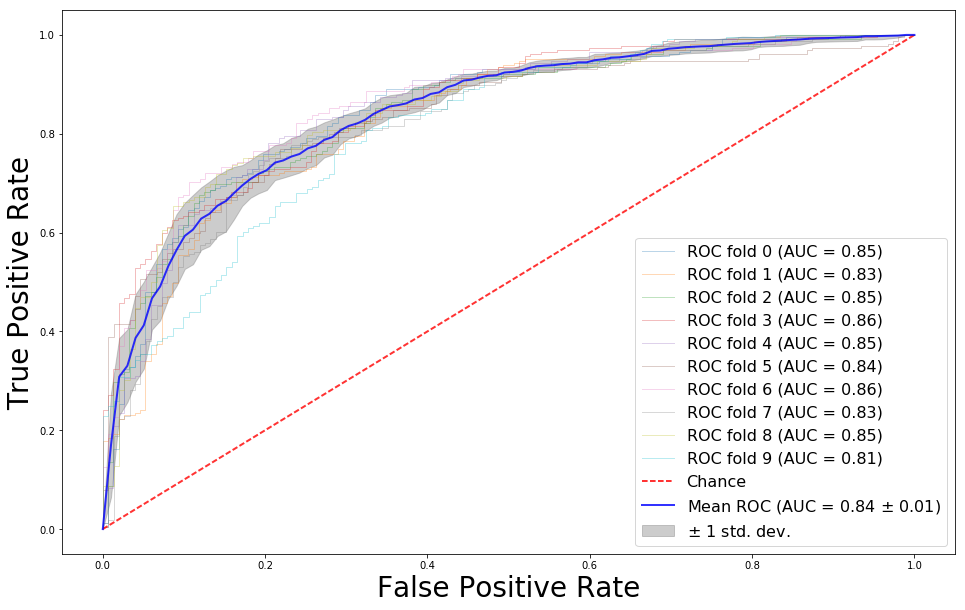

Accuracy scores: [0.7769028871391076, 0.76902887139107612, 0.76640419947506566, 0.76640419947506566, 0.78477690288713908, 0.76052631578947372, 0.80000000000000004, 0.74670184696569919, 0.76517150395778366, 0.75197889182058042]
Mean accuracy:0.7687895618900991(+/-0.01)


In [22]:
min_max_scaler = preprocessing.MinMaxScaler()

'''Use size, location, and number of people as predictors'''
do_cross_val_roc(classifier_func=LogisticRegression,
                   X= feature_df[img_level_features].apply(stats.zscore).values,
                   y=feature_df.label, n_splits=10,
                    legend_font=16,
                    label_font=28,
                    save_file='simple-predictor-roc.pdf')

## Using all high level features

             precision    recall  f1-score   support

          0       0.91      0.84      0.87       152
          1       0.90      0.94      0.92       229

avg / total       0.90      0.90      0.90       381

             precision    recall  f1-score   support

          0       0.88      0.79      0.83       152
          1       0.87      0.93      0.90       229

avg / total       0.87      0.87      0.87       381

             precision    recall  f1-score   support

          0       0.84      0.90      0.87       152
          1       0.93      0.89      0.91       229

avg / total       0.90      0.89      0.89       381

             precision    recall  f1-score   support

          0       0.84      0.88      0.86       152
          1       0.91      0.89      0.90       229

avg / total       0.89      0.88      0.88       381

             precision    recall  f1-score   support

          0       0.83      0.82      0.82       152
          1       0.88      0.89 

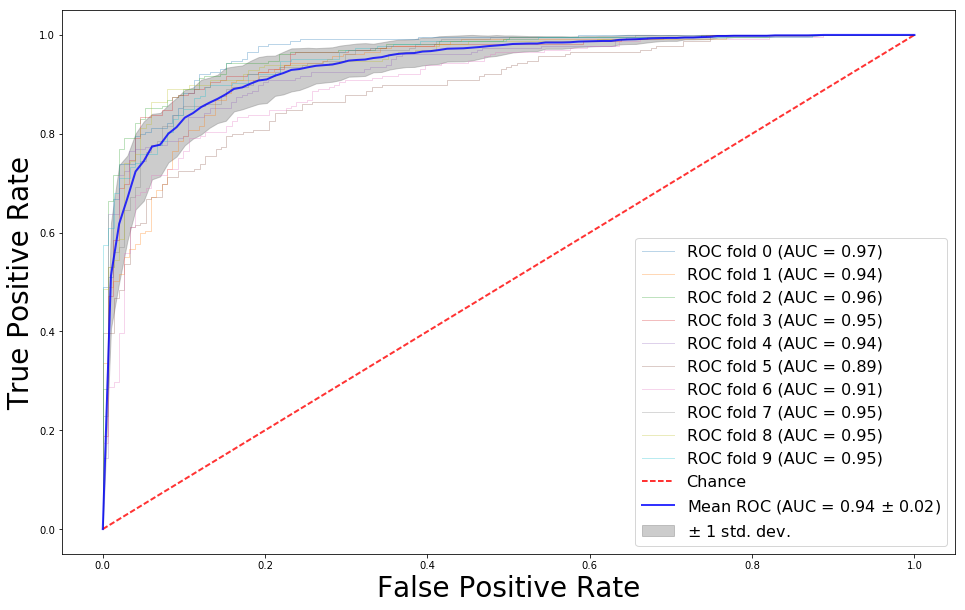

Accuracy scores: [0.90288713910761154, 0.87401574803149606, 0.8923884514435696, 0.884514435695538, 0.8582677165354331, 0.80263157894736847, 0.82894736842105265, 0.87071240105540892, 0.8812664907651715, 0.86543535620052769]
Mean accuracy:0.8661066686203178(+/-0.03)


In [24]:
'''Use survey features and person size'''
do_cross_val_roc(classifier_func=LogisticRegression,
                    X= min_max_scaler.fit_transform(
                    feature_df[features_from_study+['person_size']]),
                    y=feature_df.label, n_splits=10,
                    legend_font=16,
                    label_font=28,
                    save_file='ground-truth-high-features-roc.pdf')

             precision    recall  f1-score   support

          0       0.90      0.86      0.88       152
          1       0.91      0.93      0.92       229

avg / total       0.90      0.90      0.90       381

             precision    recall  f1-score   support

          0       0.86      0.71      0.78       152
          1       0.83      0.93      0.87       229

avg / total       0.84      0.84      0.84       381

             precision    recall  f1-score   support

          0       0.87      0.91      0.89       152
          1       0.94      0.91      0.92       229

avg / total       0.91      0.91      0.91       381

             precision    recall  f1-score   support

          0       0.84      0.86      0.85       152
          1       0.91      0.89      0.90       229

avg / total       0.88      0.88      0.88       381

             precision    recall  f1-score   support

          0       0.84      0.88      0.86       152
          1       0.91      0.89 

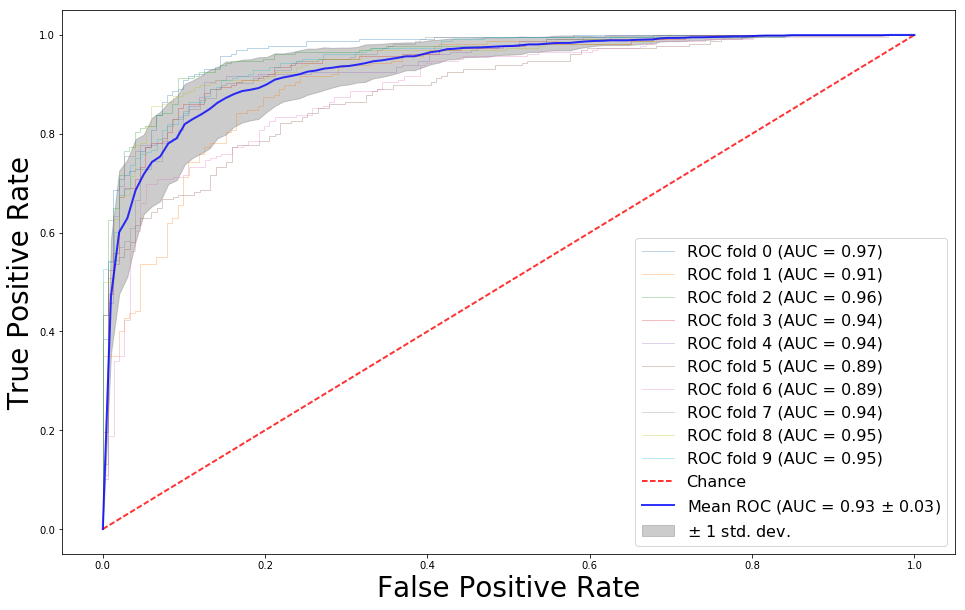

Accuracy scores: [0.90288713910761154, 0.83989501312335957, 0.91076115485564302, 0.87926509186351709, 0.884514435695538, 0.79210526315789476, 0.79473684210526319, 0.87071240105540892, 0.87071240105540892, 0.8812664907651715]
Mean accuracy:0.8626856232784815(+/-0.04)


In [26]:
'''This will be used in paper'''
'''Use selected survey features and size, location, and number of people as predictors'''
feat=['posing_num', 'replacable_num', 'photographer_intention_num','person_size']
do_cross_val_roc(classifier_func=LogisticRegression,
                    X= min_max_scaler.fit_transform(
                    feature_df[feat]),
                    y=feature_df.label, n_splits=10,
                    legend_font=16,
                    label_font=28,
                    save_file='ground-truth-pose-roc.pdf')

### Using raw cropped image as predictor

/nfs/nfs5-insecure/home/insecure-ro/software/rhel6_x86_64/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


             precision    recall  f1-score   support

          0       0.59      0.66      0.63       152
          1       0.76      0.70      0.73       229

avg / total       0.69      0.69      0.69       381

             precision    recall  f1-score   support

          0       0.61      0.65      0.63       152
          1       0.76      0.73      0.74       229

avg / total       0.70      0.70      0.70       381

             precision    recall  f1-score   support

          0       0.59      0.59      0.59       152
          1       0.73      0.72      0.73       229

avg / total       0.67      0.67      0.67       381

             precision    recall  f1-score   support

          0       0.53      0.59      0.56       152
          1       0.71      0.65      0.68       229

avg / total       0.64      0.63      0.63       381

             precision    recall  f1-score   support

          0       0.55      0.61      0.57       152
          1       0.72      0.67 

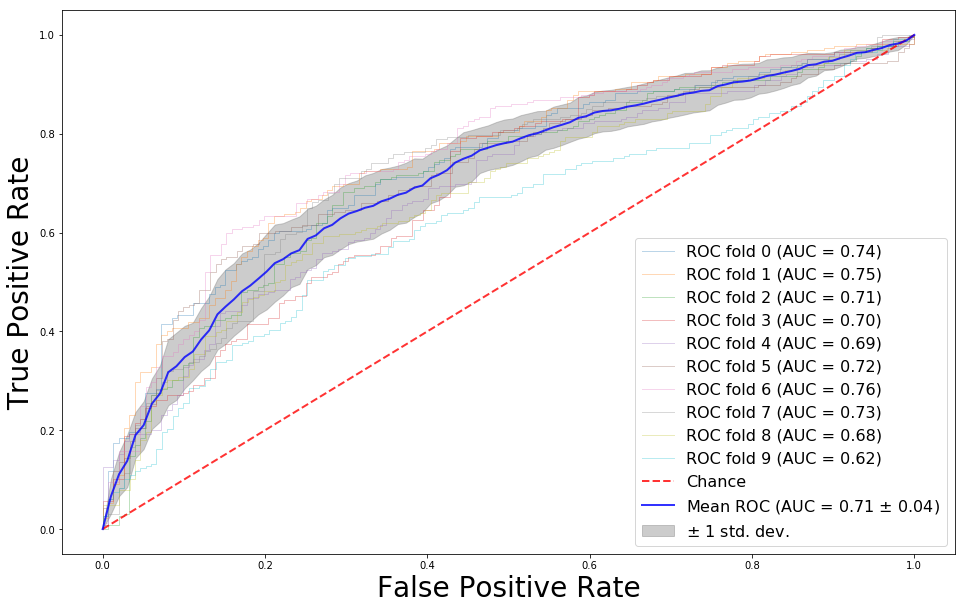

Accuracy scores: [0.6850393700787402, 0.6981627296587927, 0.6719160104986877, 0.6272965879265092, 0.6430446194225722, 0.6631578947368421, 0.6947368421052632, 0.6992084432717678, 0.6411609498680739, 0.6094986807387863]
Mean accuracy:0.6633222128306036(+/-0.03)


In [69]:
helper.do_cross_val_roc(classifier_func=LogisticRegression,
                    X= min_max_scaler.fit_transform(
                       np.array([x.flatten() for x in feature_df.resized_cropped_img])),
                    y=feature_df.label,
                    n_splits=10,
                    legend_font=16,
                    label_font=28,
                    save_file='raw-cropped-img-roc.pdf')


### Using extracted ResNet features

             precision    recall  f1-score   support

          0       0.75      0.78      0.76       152
          1       0.85      0.83      0.84       229

avg / total       0.81      0.81      0.81       381

             precision    recall  f1-score   support

          0       0.74      0.66      0.70       152
          1       0.79      0.85      0.82       229

avg / total       0.77      0.77      0.77       381

             precision    recall  f1-score   support

          0       0.76      0.68      0.72       152
          1       0.80      0.86      0.83       229

avg / total       0.78      0.78      0.78       381

             precision    recall  f1-score   support

          0       0.70      0.68      0.69       152
          1       0.79      0.80      0.80       229

avg / total       0.75      0.75      0.75       381

             precision    recall  f1-score   support

          0       0.73      0.70      0.71       152
          1       0.81      0.83 

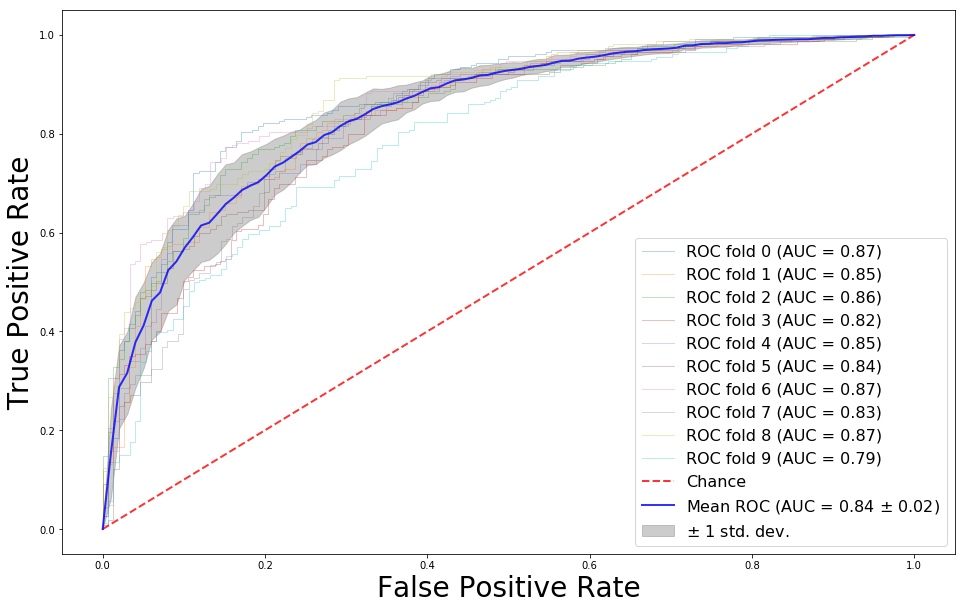

Accuracy scores: [0.8057742782152231, 0.7716535433070866, 0.7847769028871391, 0.7532808398950132, 0.7769028871391076, 0.7578947368421053, 0.7868421052631579, 0.7730870712401056, 0.8126649076517151, 0.7282321899736148]
Mean accuracy:0.775110946241427(+/-0.02)


In [70]:
helper.do_cross_val_roc(classifier_func=LogisticRegression,
                   X= min_max_scaler.fit_transform(feature_df[resnet_feat_avg_cols]),
                   y=feature_df.label, n_splits=10,
                    legend_font=16,
                    label_font=28,
                    save_file='resnet-extracted-features-roc.pdf')

### Finetune ResNet

In [51]:
'''Add result from fine-tune-ResNet.py'''

'Add result from fine-tune-ResNet.py'

### ReseNet features + Pose + Facial expression features

             precision    recall  f1-score   support

          0       0.75      0.78      0.76       152
          1       0.85      0.83      0.84       229

avg / total       0.81      0.81      0.81       381

             precision    recall  f1-score   support

          0       0.75      0.68      0.72       152
          1       0.80      0.85      0.83       229

avg / total       0.78      0.78      0.78       381

             precision    recall  f1-score   support

          0       0.78      0.70      0.74       152
          1       0.81      0.87      0.84       229

avg / total       0.80      0.80      0.80       381

             precision    recall  f1-score   support

          0       0.71      0.72      0.71       152
          1       0.81      0.80      0.81       229

avg / total       0.77      0.77      0.77       381

             precision    recall  f1-score   support

          0       0.72      0.67      0.70       152
          1       0.79      0.83 

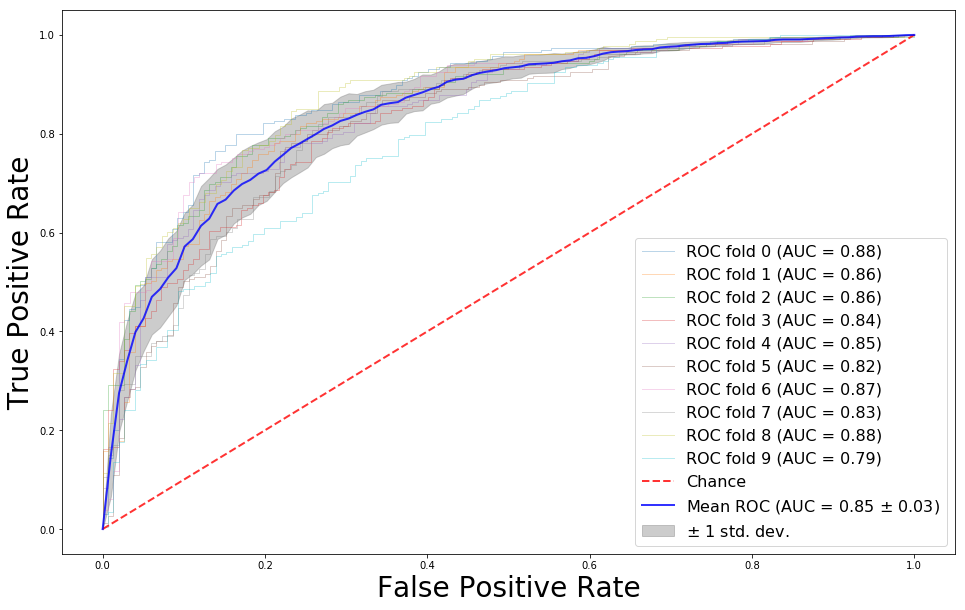

Accuracy scores: [0.8083989501312336, 0.7847769028871391, 0.800524934383202, 0.7690288713910761, 0.7664041994750657, 0.7710526315789473, 0.7868421052631579, 0.7862796833773087, 0.8258575197889182, 0.7097625329815304]
Mean accuracy:0.780892833125758(+/-0.03)


In [72]:
helper.do_cross_val_roc(classifier_func=LogisticRegression,
                   X=  min_max_scaler.fit_transform(feature_df[resnet_feat_avg_cols+body_joint_prob_features+\
                                link_angle_features+ face_exp_feaures]),
                   y=feature_df.label, n_splits=10,
                    legend_font=16,
                    label_font=28,
                  save_file='all-visual-features-roc.pdf')

### ResNet features + Survey features + Image level features

             precision    recall  f1-score   support

          0       0.86      0.80      0.83       505
          1       0.87      0.91      0.89       763

avg / total       0.87      0.87      0.87      1268

             precision    recall  f1-score   support

          0       0.78      0.85      0.82       505
          1       0.90      0.84      0.87       762

avg / total       0.85      0.85      0.85      1267

             precision    recall  f1-score   support

          0       0.83      0.79      0.81       505
          1       0.86      0.90      0.88       762

avg / total       0.85      0.85      0.85      1267



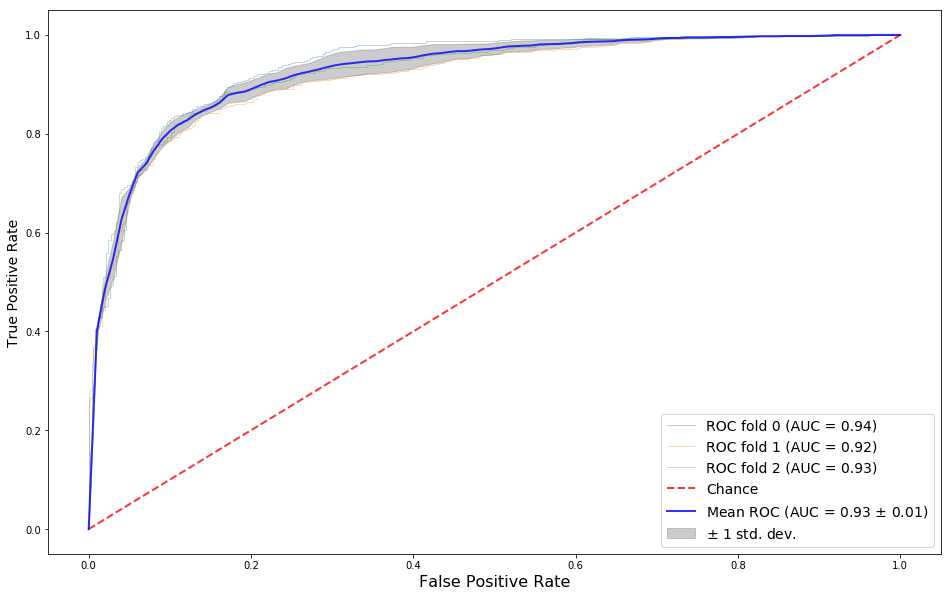

Accuracy scores: [0.8667192429022083, 0.846093133385951, 0.8524072612470402]
Mean accuracy:0.8550732125117332(+/-0.01)


In [51]:
do_cross_val_roc2(classifier_func=LogisticRegression,
                   X=  min_max_scaler.fit_transform(
    feature_df[resnet_feat_avg_cols+features_from_study]),
                   y=feature_df.label, n_splits=3,
                    legend_font=14)

# Exploratory analysis

In [ ]:
# This will break code execution
asfd

In [149]:
#fine_tune_cv_mixed_features(resnet_mixed_features, feature_df, features_from_study, save_model=False, epochs=1)
scores = do_cross_validation(dense_model,feature_df[features_from_study].values,
     feature_df.label, epochs= 2, n_splits = 3, model_args ={'input_dim':len(features_from_study), 
        'hidden_dims':[]}, save_model=False)
scores

Epoch 1/2
2534/2534 [==============================] - 1s 311us/step - loss: 1.6846 - acc: 0.7715 - precision: 0.9470 - recall: 0.6606 - f1_score: 0.7759
Epoch 2/2
1268/1268 [==============================] - 1s 630us/step
['loss', 'acc', 'precision', 'recall', 'f1_score'] [1.439551291029536, 0.7791798105375248, 0.9497206702142048, 0.6684141545650834, 0.7846153360058018]
Epoch 1/2
2535/2535 [==============================] - 1s 333us/step - loss: 2.5762 - acc: 0.5321 - precision: 0.8032 - recall: 0.2944 - f1_score: 0.4309
Epoch 2/2
1267/1267 [==============================] - 1s 606us/step
['loss', 'acc', 'precision', 'recall', 'f1_score'] [2.1479499750280344, 0.5627466456666177, 0.8270440248971559, 0.34514435691008605, 0.4870369953974658]
Epoch 1/2
2535/2535 [==============================] - 1s 380us/step - loss: 2.6676 - acc: 0.3278 - precision: 0.4519 - recall: 0.5107 - f1_score: 0.4795
Epoch 2/2
1267/1267 [==============================] - 1s 687us/step
['loss', 'acc', 'precision'

[[1.439551291029536,
  0.7791798105375248,
  0.9497206702142048,
  0.6684141545650834,
  0.7846153360058018],
 [2.1479499750280344,
  0.5627466456666177,
  0.8270440248971559,
  0.34514435691008605,
  0.4870369953974658],
 [2.1773041992932676,
  0.3425414360877371,
  0.4601571267721485,
  0.538057742711541,
  0.4942736090458837]]

In [160]:
print('acc: {:.4f} +/- {:.4f}\nprecision: {:.4f} +/- {:.4f}\nrecall: {:.4f} +/- {:.4f}\nf1: {:.4f} +/- {:.4f}'.format(
    np.mean([s[1] for s in scores]), np.std([s[1] for s in scores]),
    np.mean([s[2] for s in scores]), np.std([s[2] for s in scores]),
    np.mean([s[3] for s in scores]), np.std([s[3] for s in scores]),
    np.mean([s[4] for s in scores]), np.std([s[4] for s in scores])))

acc: 0.5615 +/- 0.1783
precision: 0.7456 +/- 0.2080
recall: 0.5172 +/- 0.1328
f1: 0.5886 +/- 0.1386


## SVM with high level features

In [8]:
feat = img_level_features
print('Features:',feat)
rbf_svm = svm.SVC(kernel='rbf', C=1)
scores = cross_val_score(rbf_svm, feature_df[feat].apply(stats.zscore), feature_df.label, cv=5)
print("RBF kernel accuracy: %0.2f (+/- %0.2f)" % (scores.mean()*100, scores.std() * 2*100))
print()

feat = features_from_study
print('Features:',feat)
rbf_svm = svm.SVC(kernel='rbf', C=1)
scores = cross_val_score(rbf_svm, feature_df[feat].apply(stats.zscore), feature_df.label, cv=5)
print("RBF kernel accuracy: %0.2f (+/- %0.2f)" % (scores.mean()*100, scores.std() * 2*100))
print()

feat = features_from_study + img_level_features
print('Features:',feat)
rbf_svm = svm.SVC(kernel='rbf', C=1)
scores = cross_val_score(rbf_svm, feature_df[feat].apply(stats.zscore), feature_df.label, cv=5)
print("RBF kernel accuracy: %0.2f (+/- %0.2f)" % (scores.mean()*100, scores.std() * 2*100))
print()

Features: ['person_distance', 'person_size', 'num_people']
RBF kernel accuracy: 78.27 (+/- 1.44)

Features: ['was_aware_num', 'posing_num', 'comfort_num', 'will_num', 'photographer_intention_num', 'replacable_num', 'photo_place_num']
RBF kernel accuracy: 86.32 (+/- 6.02)

Features: ['was_aware_num', 'posing_num', 'comfort_num', 'will_num', 'photographer_intention_num', 'replacable_num', 'photo_place_num', 'person_distance', 'person_size', 'num_people']
RBF kernel accuracy: 88.06 (+/- 4.83)



### Logistic regression with high level features

In [7]:
lr = LogisticRegression()
feat = ['person_distance', 'person_size', 'num_people']
print('Features:',feat)
scores = cross_val_score(lr, feature_df[feat].apply(stats.zscore), feature_df.label, cv=10)
print("Logistic regression accuracy: %0.2f (+/- %0.2f)" % (scores.mean()*100, scores.std() * 2*100))

lr = LogisticRegression()
feat = features_from_study
print('Features:',feat)
scores = cross_val_score(lr, feature_df[feat].apply(stats.zscore), feature_df.label, cv=10)
print("Logistic regression accuracy: %0.2f (+/- %0.2f)" % (scores.mean()*100, scores.std() * 2*100))


lr = LogisticRegression()
feat = ['person_distance', 'person_size', 'num_people'] + features_from_study
print('Features:',feat)
scores = cross_val_score(lr, feature_df[feat].apply(stats.zscore), feature_df.label, cv=10)
print("Logistic regression accuracy: %0.2f (+/- %0.2f)" % (scores.mean()*100, scores.std() * 2*100))

Features: ['person_distance', 'person_size', 'num_people']
Logistic regression accuracy: 76.88 (+/- 2.94)
Features: ['was_aware_num', 'posing_num', 'comfort_num', 'will_num', 'photographer_intention_num', 'replacable_num', 'photo_place_num']
Logistic regression accuracy: 85.93 (+/- 6.74)
Features: ['person_distance', 'person_size', 'num_people', 'was_aware_num', 'posing_num', 'comfort_num', 'will_num', 'photographer_intention_num', 'replacable_num', 'photo_place_num']
Logistic regression accuracy: 87.72 (+/- 5.98)


### Logistic regression with CNN features

**NOTE**

- Resnet has batchnormalization layer, so the features extracted from it are batch normalized, which is different from normalizing the whole dataset. How does it affect training LR/SVM with these features?
- Some columns of resnet features contain only zero, so for now not performing zscore transformation.



In [65]:
min_max_scaler = preprocessing.MinMaxScaler()
lr = LogisticRegression()
scores = cross_val_score(lr, feature_df[resnet_feat_avg_cols], feature_df.label, cv=5)
print("Logistic regression accuracy: %0.2f (+/- %0.2f)" % (scores.mean()*100, scores.std() * 2*100))

Logistic regression accuracy: 71.44 (+/- 1.81)


In [83]:
'''Run lr_resnet_no_hidden.py'''
'without any normalization: accuracy = 78.56% (+/- 0.81%). using zscore: accuracy = 77.99% (+/- 0.98%)'

'without any normalization: accuracy = 78.56% (+/- 0.81%). using zscore: accuracy = 77.99% (+/- 0.98%)'

In [69]:
'''Run lr_resnet_1_hidden.py, with one intermediate layer of 64 nodes'''
'without any normalization, splits=5: accuracy = 76.56% (+/- 0.81%). without any normalization, splits=10: accuracy = 76.22% (+/- 1.52%)'

'without any normalization, splits=5: accuracy = 76.56% (+/- 0.81%). without any normalization, splits=10: accuracy = 76.22% (+/- 1.52%)'

In [90]:
Xtrain,Ytrain,Xtest,Ytest = split_data(min_max_scaler.fit_transform(
    feature_df[features_from_study]), feature_df.label)


### Logistic regression with CNN + survey_features

In [11]:
min_max_scaler = preprocessing.MinMaxScaler()
lr = LogisticRegression()
scores = cross_val_score(lr, min_max_scaler.fit_transform(
    feature_df[resnet_feature_cols+features_from_study]), feature_df.label, cv=5)
print("Logistic regression accuracy: %0.2f (+/- %0.2f)" % (scores.mean()*100, scores.std() * 2*100))

Logistic regression accuracy: 81.67 (+/- 3.20)


In [50]:
min_max_scaler = preprocessing.MinMaxScaler()
lr = LogisticRegression()
scores = cross_val_score(lr, min_max_scaler.fit_transform(
    feature_df[resnet_feat_avg_cols+features_from_study]), feature_df.label, cv=5)
print("Logistic regression accuracy: %0.2f (+/- %0.2f)" % (scores.mean()*100, scores.std() * 2*100))

Logistic regression accuracy: 86.01 (+/- 3.63)


In [24]:


min_max_scaler = preprocessing.MinMaxScaler()

Xtrain,Ytrain,Xtest,Ytest = split_data(min_max_scaler.fit_transform(
    feature_df[resnet_feature_cols+features_from_study]), feature_df.label)
lr_clf = LogisticRegression(max_iter=50).fit(Xtrain, Ytrain)
lr_clf.score(Xtest, Ytest)

0.8289473684210527

### Logistic regression with CNN+suvey+ image level features

In [55]:
min_max_scaler = preprocessing.MinMaxScaler()
lr = LogisticRegression()
scores = cross_val_score(lr, min_max_scaler.fit_transform(
    feature_df[resnet_feat_avg_cols+features_from_study+img_level_features]), feature_df.label, cv=10)
print("Logistic regression accuracy: %0.2f (+/- %0.2f)" % (scores.mean()*100, scores.std() * 2*100))

Logistic regression accuracy: 86.74 (+/- 6.65)


### Logistic regression with all features

In [72]:
min_max_scaler = preprocessing.MinMaxScaler()
lr = LogisticRegression()
scores = cross_val_score(lr, min_max_scaler.fit_transform(feature_df[all_features]), feature_df.label, cv=10)
print("Logistic regression accuracy: %0.2f (+/- %0.2f)" % (scores.mean()*100, scores.std() * 2*100))

Logistic regression accuracy: 86.85 (+/- 7.81)


In [82]:
'''run lr_resnet+other_no_hidden'''
print('without min_max_scaler: 77.88% (+/- 1.93%), 78.36% (+/- 1.84%),80.59% (+/- 1.67%)')
print('with min_max_scaler: 65.15% (+/- 4.10%), 66.97% (+/- 3.33%), 69.10% (+/- 2.55%)')

without min_max_scaler: 77.88% (+/- 1.93%), 78.36% (+/- 1.84%),80.59% (+/- 1.67%)
with min_max_scaler: 65.15% (+/- 4.10%), 66.97% (+/- 3.33%), 69.10% (+/- 2.55%)


In [81]:
'''run lr_resnet+other_1_hidden'''
print('without min_max_scaler: 76.64% (+/- 1.31%), 78.62% (+/- 1.90%), 85.56% (+/- 1.92%)')
print('with min_max_scaler: 76.33% (+/- 2.16%), 78.83% (+/- 1.58%),84.98% (+/- 1.02%)')

without min_max_scaler: 76.64% (+/- 1.31%), 78.62% (+/- 1.90%), 85.56% (+/- 1.92%)
with min_max_scaler: 76.33% (+/- 2.16%), 78.83% (+/- 1.58%),84.98% (+/- 1.02%)


### SVM with CNN features

In [220]:
'''Feed CNN features directly into SVM'''
min_max_scaler = preprocessing.MinMaxScaler()
clf = svm.SVC(kernel='linear', C=1)
scores = cross_val_score(clf, min_max_scaler.fit_transform(
    feature_df[resnet_feature_cols]), feature_df.label, cv=5)
print("Linear kernel accuracy: %0.2f (+/- %0.2f)" % (scores.mean()*100, scores.std() * 2*100))

Linear kernel accuracy: 71.37 (+/- 2.50)


In [271]:
clf = svm.SVC(kernel='rbf', C=1)
min_max_scaler = preprocessing.MinMaxScaler()
scores = cross_val_score(clf, min_max_scaler.fit_transform(
    feature_df[resnet_feature_cols]), feature_df.label, cv=5)
print("RBF kernel accuracy: %0.2f (+/- %0.2f)" % (scores.mean()*100, scores.std() * 2*100))

RBF kernel accuracy: 56.89 (+/- 0.79)


In [ ]:
'''Do cross-validation by first fine-tuning resnet model with raw cropped image.'''
scores = do_cross_validation(resnet_with_imagenet,
        feature_df.resized_cropped_img, feature_df.label, epochs= 60, n_splits = 2)
#clear_output()
print("%.2f%% (+/- %.2f%%)" % (np.mean(scores), np.std(scores)))

In [ ]:
import os
 
import sklearn
from sklearn import cross_validation, grid_search
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.externals import joblib
 
def train_svm_classifer(features, labels, model_output_path):
    """
    train_svm_classifer will train a SVM, saved the trained and SVM model and
    report the classification performance
 
    features: array of input features
    labels: array of labels associated with the input features
    model_output_path: path for storing the trained svm model
    """
    # save 20% of data for performance evaluation
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(features, labels, test_size=0.2)
 
    param = [
        {
            "kernel": ["linear"],
            "C": [1, 10, 100, 1000]
        },
        {
            "kernel": ["rbf"],
            "C": [1, 10, 100, 1000],
            "gamma": [1e-2, 1e-3, 1e-4, 1e-5]
        }
    ]
 
    # request probability estimation
    svm = SVC(probability=True)
 
    # 10-fold cross validation, use 4 thread as each fold and each parameter set can be train in parallel
    clf = grid_search.GridSearchCV(svm, param,
            cv=10, n_jobs=4, verbose=3)
 
    clf.fit(X_train, y_train)
 
    if os.path.exists(model_output_path):
        joblib.dump(clf.best_estimator_, model_output_path)
    else:
        print("Cannot save trained svm model to {0}.".format(model_output_path))
 
    print("\nBest parameters set:")
    print(clf.best_params_)
 
    y_predict=clf.predict(X_test)
 
    labels=sorted(list(set(labels)))
    print("\nConfusion matrix:")
    print("Labels: {0}\n".format(",".join(labels)))
    print(confusion_matrix(y_test, y_predict, labels=labels))
 
    print("\nClassification report:")
    print(classification_report(y_test, y_predict))

In [2]:
rn = resnet_model()

NameError: name 'resnet_model' is not defined

In [37]:
# '''Feed CNN features directly into SVM'''
# clf = svm.SVC(kernel='linear', C=1)
# scores = cross_val_score(clf, cnn_feats, Y, cv=5)
# print("Linear kernel accuracy: %0.2f (+/- %0.2f)" % (scores.mean()*100, scores.std() * 2*100))

# clf = svm.SVC(kernel='rbf', C=1)
# scores = cross_val_score(clf, cnn_feats, Y, cv=5)
# print("RBF kernel accuracy: %0.2f (+/- %0.2f)" % (scores.mean()*100, scores.std() * 2*100))

Linear kernel accuracy: 64.75 (+/- 5.35)
RBF kernel accuracy: 53.78 (+/- 0.60)


In [ ]:
# '''Confusion matrix'''
# #(Xtrain, Ytrain),(Xtest,Ytest) = split_data(cnn_feats, Y)
# clf = svm.SVC(kernel='linear', C=1)
# clf.fit(Xtrain,Ytrain)
# predictions = clf.predict(Xtest)
# print(confusion_matrix(Ytest, predictions))

In [138]:

# '''Feed CNN features directly into SVM'''
# clf = svm.SVC(kernel='linear', C=1)
# scores = cross_val_score(clf, np.array(
#     [v for v in all_feat_df['cnn_feat_transformed'].values]).reshape(437, 131072), all_feat_df.label, cv=5)
# print("Linear kernel accuracy: %0.2f (+/- %0.2f)" % (scores.mean()*100, scores.std() * 2*100))

# clf = svm.SVC(kernel='rbf', C=1)
# scores = cross_val_score(clf, np.array(
#     [v for v in all_feat_df['cnn_feat_transformed'].values]).reshape(437, 131072), all_feat_df.label, cv=5)

# print("RBF kernel accuracy: %0.2f (+/- %0.2f)" % (scores.mean()*100, scores.std() * 2*100))

Linear kernel accuracy: 64.75 (+/- 5.35)
RBF kernel accuracy: 53.78 (+/- 0.60)


In [146]:
# clf = svm.SVC(kernel='linear', C=1)
# scores = cross_val_score(clf, np.array(
#     [v for v in all_feat_df['combined_feat'].values]).reshape(437, 131108), all_feat_df.label, cv=5)
# print("Linear kernel accuracy: %0.2f (+/- %0.2f)" % (scores.mean()*100, scores.std() * 2*100))

# clf = svm.SVC(kernel='rbf', C=1)
# scores = cross_val_score(clf, np.array(
#     [v for v in all_feat_df['combined_feat'].values]).reshape(437, 131108), all_feat_df.label, cv=5)

# print("RBF kernel accuracy: %0.2f (+/- %0.2f)" % (scores.mean()*100, scores.std() * 2*100))

Linear kernel accuracy: 65.21 (+/- 6.78)
RBF kernel accuracy: 53.78 (+/- 0.60)


In [116]:
clf = svm.SVC(kernel='linear', C=1)
scores = cross_val_score(clf, min_max_scaler.fit_transform(feature_df[high_level_features]), feature_df.label, cv=5)
print("Linear kernel accuracy: %0.2f (+/- %0.2f)" % (scores.mean()*100, scores.std() * 2*100))

Linear kernel accuracy: 79.86 (+/- 5.03)


In [117]:

clf = svm.SVC(kernel='linear', C=1)
scores = cross_val_score(clf, min_max_scaler.fit_transform(
    feature_df[high_level_features+['person_distance', 'person_size', 'num_people']]), feature_df.label, cv=5)
print("Linear kernel accuracy: %0.2f (+/- %0.2f)" % (scores.mean()*100, scores.std() * 2*100))

Linear kernel accuracy: 81.82 (+/- 4.77)


In [120]:
clf = svm.SVC(kernel='rbf', C=1)
scores = cross_val_score(clf, min_max_scaler.fit_transform(
    feature_df[high_level_features+['person_distance', 'person_size', 'num_people']]), feature_df.label, cv=5)
print("RBF kernel accuracy: %0.2f (+/- %0.2f)" % (scores.mean()*100, scores.std() * 2*100))

RBF kernel accuracy: 81.99 (+/- 4.54)


### Useful code blocks

In [156]:
'''convert raw image data in np array'''
#X_train = np.array([x for x in feature_df.resized_cropped_img])
#X_test = np.array([x for x in feature_df.resized_cropped_img])

In [157]:
X_train.shape

(5, 256, 256, 3)